In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_token_len=256, include_labels=True):
        self.tokenizer = tokenizer
        self.data = dataframe.fillna('')
        self.max_token_len = max_token_len
        self.include_labels = include_labels

    def __len__(self):
        return len(self.data)

    def _standardize_diacritics(self, text):
        """
        Standardizes Romanian diacritics in the given text.
        """
        return text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș")

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        text = self._standardize_diacritics(data_row.title) + " " + self._standardize_diacritics(data_row.content)
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        item = {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

        if self.include_labels:
            labels = data_row.get('class')
            item["labels"] = torch.tensor(labels, dtype=torch.long)

        return item


In [3]:
class NewsClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, steps_per_epoch=None, n_epochs=None, lr=2e-5):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self.forward(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [4]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

MODEL_NAME = "dumitrescustefan/bert-base-romanian-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

train_df = load_data("train.csv")
test_df = load_data("test.csv")

In [5]:
# Resampling date

X = train_df[['title', 'content']].values
y = train_df['class'].values.reshape(-1, 1)

ros = RandomOverSampler(random_state=42)

X_res, y_res = ros.fit_resample(X, y)

resampled_train_df = pd.DataFrame(X_res, columns=['title', 'content'])
resampled_train_df['class'] = y_res

In [6]:
train_dataset = NewsDataset(resampled_train_df, tokenizer)
test_dataset = NewsDataset(test_df, tokenizer, include_labels=False)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

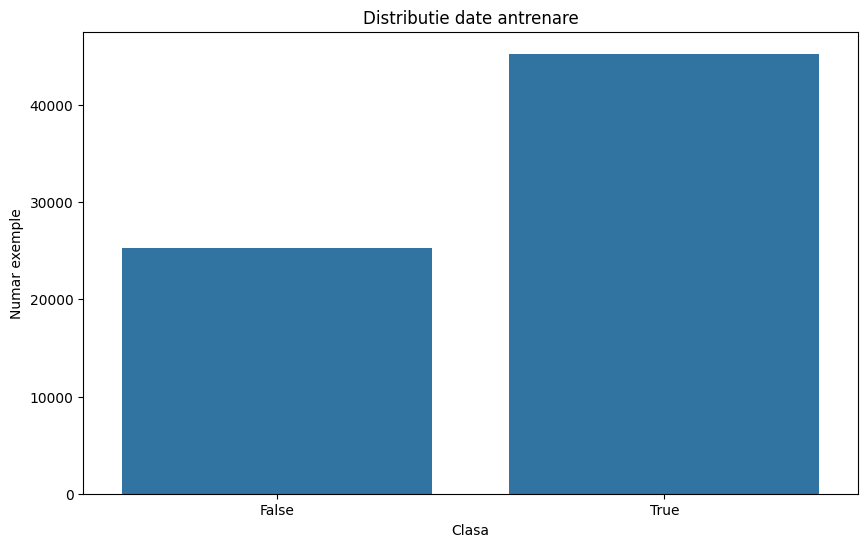

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_df)
plt.title('Distributie date antrenare')
plt.xlabel('Clasa')
plt.ylabel('Numar exemple')
plt.show()

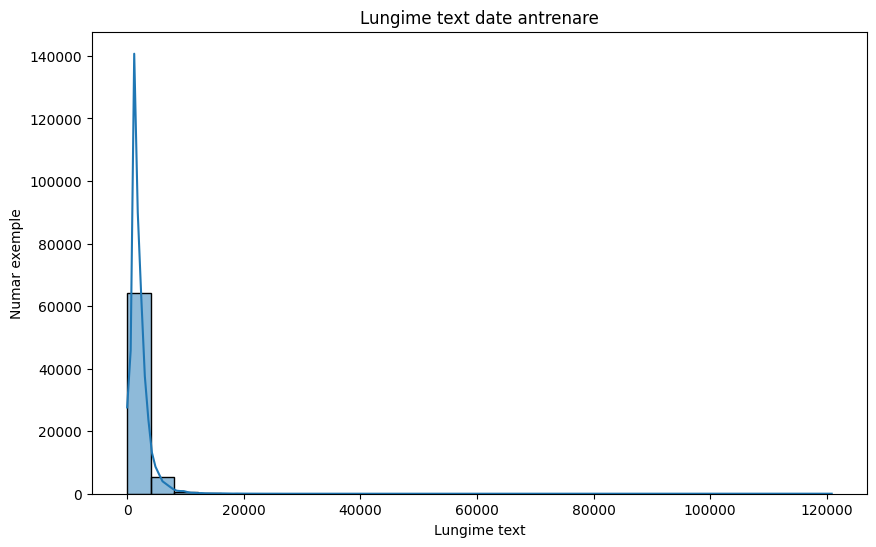

In [8]:
train_df['title'] = train_df['title'].fillna('')
train_df['content'] = train_df['content'].fillna('')

train_df['text_length'] = train_df.apply(lambda row: len(row['title'] + " " + row['content']), axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title('Lungime text date antrenare')
plt.xlabel('Lungime text')
plt.ylabel('Numar exemple')
plt.show()

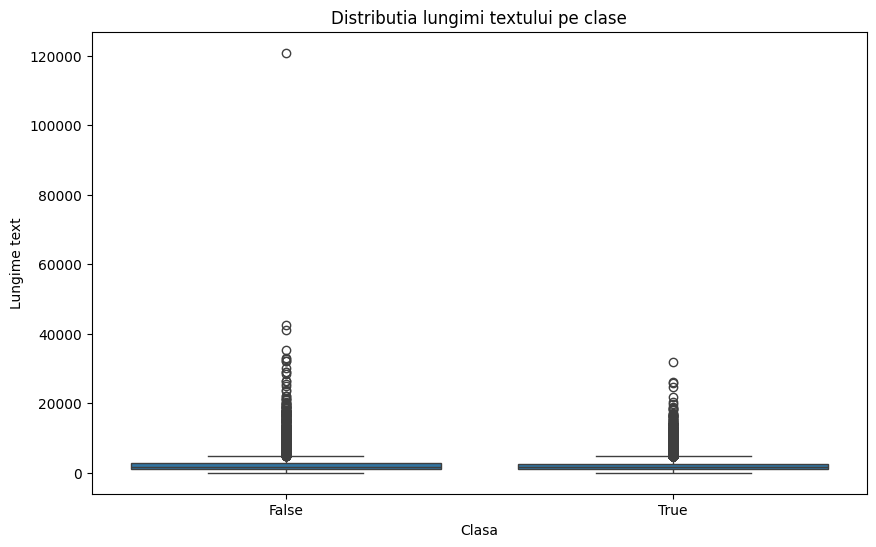

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='text_length', data=train_df)
plt.title('Distributia lungimi textului pe clase')
plt.xlabel('Clasa')
plt.ylabel('Lungime text')
plt.show()

In [10]:
checkpoint_callback = ModelCheckpoint(
    dirpath="models/",
    filename="resampled-balanced-classifier-{epoch:02d}-{val_loss:.2f}",
    save_top_k=-1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

num_classes = train_df['class'].nunique()
unique_classes = np.unique(train_df['class'])

model = NewsClassifier(n_classes=num_classes, steps_per_epoch=len(train_loader), n_epochs=3, lr=2e-5)

class_weights = compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=train_df['class']
)

assert len(class_weights) == num_classes, "nr ponderi = nr clase"

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=model.device)

model.criterion = nn.CrossEntropyLoss()

trainer = pl.Trainer(max_epochs=3, accelerator="auto", devices=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/data-scaling-bachelor/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/miniconda3/envs/data-scaling-bachelor/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name       | Type             | Params
---------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

/var/folders/jl/rspshmwd00702rbckt2npqsc0000gn/T/ipykernel_61511/2539280457.py:38: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  item["labels"] = torch.tensor(labels, dtype=torch.long)
/opt/miniconda3/envs/data-scaling-bachelor/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
Epoch 0, global step 5659: 'val_loss' was not in top -1
Epoch 1, global step 11318: 'val_loss' was not in top -1
Epoch 2, global step 16977: 'val_loss' was not in top -1
`Trainer.fit` stopped: `max_epochs=3` reached.


In [11]:
model_path = "modelul_meu_antrenat-balanced-resampled.pth"
torch.save(model.state_dict(), model_path)

In [12]:
model.eval()

predictions = []

i = 1

with torch.no_grad():    
    for batch in test_loader:
        #print(batch)
        input_ids = batch['input_ids'].to(model.device)
        #print(input_ids)
        attention_mask = batch['attention_mask'].to(model.device)
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs[1], dim=1)
        predictions.extend(preds.cpu().numpy())
        print(f"Step {i} {i*16}/{len(test_df['id'])}")
        i = i + 1
        
print(predictions)


submission_df = pd.DataFrame({'id': test_df['id'], 'class': predictions})
submission_df.to_csv('submission_sampled_balanced.csv', index=False)


Step 1 16/36669
Step 2 32/36669
Step 3 48/36669
Step 4 64/36669
Step 5 80/36669
Step 6 96/36669
Step 7 112/36669
Step 8 128/36669
Step 9 144/36669
Step 10 160/36669
Step 11 176/36669
Step 12 192/36669
Step 13 208/36669
Step 14 224/36669
Step 15 240/36669
Step 16 256/36669
Step 17 272/36669
Step 18 288/36669
Step 19 304/36669
Step 20 320/36669
Step 21 336/36669
Step 22 352/36669
Step 23 368/36669
Step 24 384/36669
Step 25 400/36669
Step 26 416/36669
Step 27 432/36669
Step 28 448/36669
Step 29 464/36669
Step 30 480/36669
Step 31 496/36669
Step 32 512/36669
Step 33 528/36669
Step 34 544/36669
Step 35 560/36669
Step 36 576/36669
Step 37 592/36669
Step 38 608/36669
Step 39 624/36669
Step 40 640/36669
Step 41 656/36669
Step 42 672/36669
Step 43 688/36669
Step 44 704/36669
Step 45 720/36669
Step 46 736/36669
Step 47 752/36669
Step 48 768/36669
Step 49 784/36669
Step 50 800/36669
Step 51 816/36669
Step 52 832/36669
Step 53 848/36669
Step 54 864/36669
Step 55 880/36669
Step 56 896/36669
Step 57